In [6]:
# Import useful libraries
import gdeltxp
import gdeltviz
import operator
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from math import isnan
from datetime import datetime
from collections import Counter, OrderedDict
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

# Declare global variables
gdelt = pd.read_csv('C:/Users/Administrator/Dropbox/GDELT/all_events.csv').sort_values('SQLDATE', ascending=1)
tweet_volumes = pd.read_csv('C:/Users/Administrator/Dropbox/TWITTER/daily_tweet_volume.csv').sort_values('Dates', ascending=1)
tweet_timestamps = pd.read_csv('C:/Users/Administrator/Dropbox/TWITTER/tweet_timestamps.csv')
dates = sorted([key for key in Counter(gdelt['SQLDATE']).keys()])

In [7]:
df = pd.DataFrame()
time = sorted([datetime.strptime(date, '%a %b %d %H:%M:%S +0000 %Y') for date in list(tweet_timestamps.Timestamp)])
deltas = [(time[i+1] - time[i]).seconds for i in range(len(time)-1)]
gdelt_activity = [len(gdelt.loc[gdelt['SQLDATE'] == date]) for date in dates]
tweet_activity = [np.sum(tweet_volumes.loc[tweet_volumes['Dates'] == date, 'counts']) for date in dates]
df['time'] = time

In [8]:
def inter_arrival_time(start, end):
    time_var = list(df.loc[(df['time'] >= start) & (df['time'] <= end)].time)
    deltas = np.array([(time_var[i+1] - time_var[i]).seconds for i in range(len(time_var)-1)])
    return deltas

# Time Series Analysis

In [9]:
window = 7
ind = np.arange(len(dates)) 
tweet_activity_sma = gdeltxp.movingAverage(tweet_activity, window)
gdelt_activity_sma = gdeltxp.movingAverage(gdelt_activity, window)

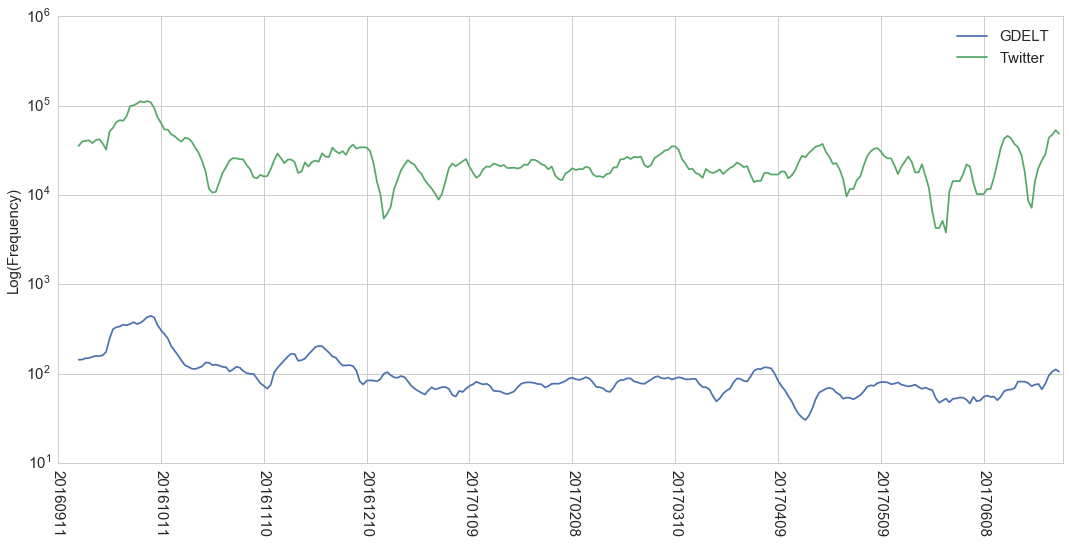

In [10]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_xlabel('', fontsize=15)
ax.set_ylabel('Log(Frequency)' , fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(np.arange(0, len(dates), 30))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
ax.set_yscale('log')
plt.xlim([0,len(dates)])
ax.set_xticklabels(dates[::30])
plt.plot(ind[len(gdelt_activity)-len(gdelt_activity_sma):], gdelt_activity_sma, label='GDELT')
plt.plot(ind[len(tweet_activity)-len(tweet_activity_sma):], tweet_activity_sma, label='Twitter')
plt.legend(loc='best', fontsize=15)
plt.show()

# Cumulative Distribution Function (CDF)

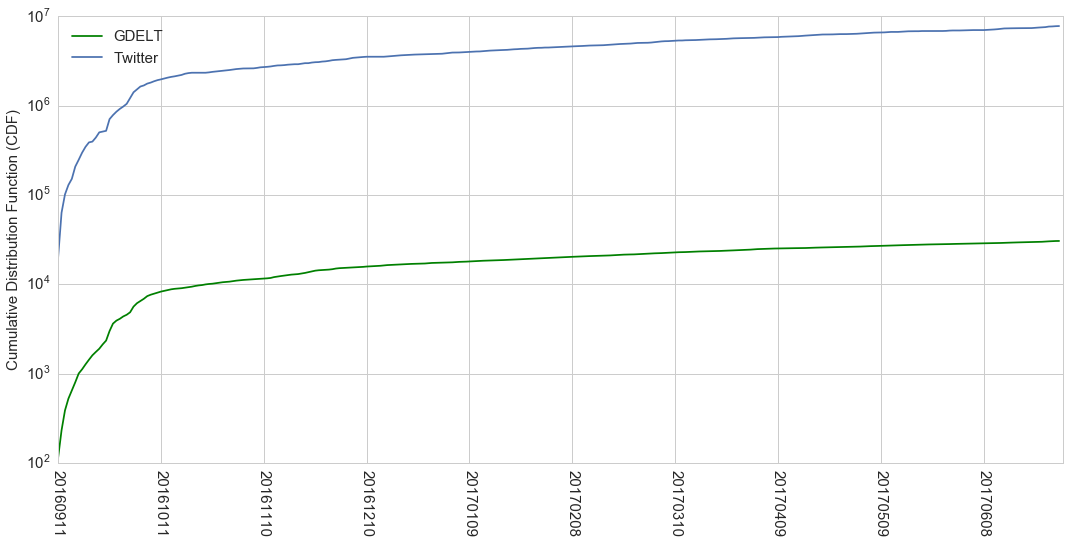

In [11]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
fig, ax = plt.subplots(figsize=(18, 8))
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_xlabel('', fontsize=15)
ax.set_ylabel('Cumulative Distribution Function (CDF)' , fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(np.arange(0, len(dates), 30))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
ax.set_yscale('log')
plt.xlim([0,len(dates)])
ax.set_xticklabels(dates[::30])
plt.plot(ind, np.cumsum(gdelt_activity), label='GDELT', c='g')
plt.plot(ind, np.cumsum(tweet_activity), label='Twitter')
#plt.plot(ind, scaler.fit_transform(np.cumsum(gdelt_activity).reshape(-1,1)), label='GDELT')
#plt.plot(ind, scaler.fit_transform(np.cumsum(tweet_activity).reshape(-1,1)), label='Twitter')
plt.legend(loc='best', fontsize=15)
plt.show()

# Correlation Analysis

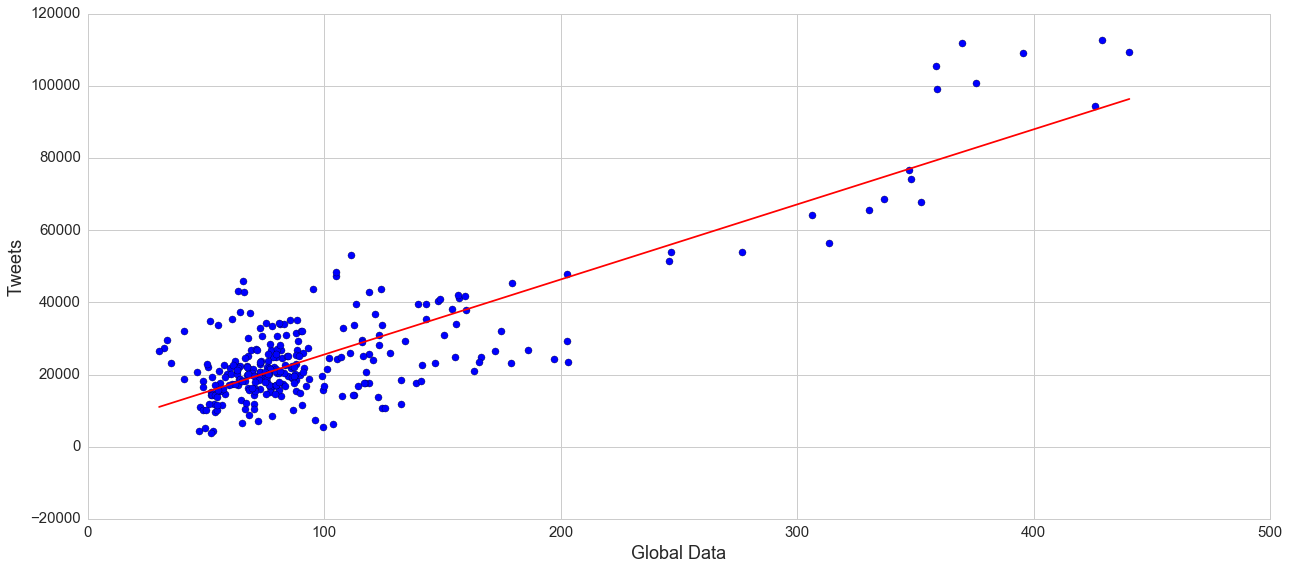

In [12]:
fig, ax = plt.subplots(figsize= (18, 8))
ax.set_title('', fontsize=15, fontweight='bold')
plt.scatter(gdelt_activity_sma,tweet_activity_sma, s=50) #s=120
plt.plot(np.unique(gdelt_activity_sma), np.poly1d(np.polyfit(gdelt_activity_sma, tweet_activity_sma, 1))(np.unique(gdelt_activity_sma)), c='r')
#ax.set_xticks(np.arange(0, 5, 1))
ax.set_xlabel('Global Data', fontsize=18)
ax.set_ylabel('Tweets' , fontsize=18)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
#plt.axhline(y=80000, color='k', linestyle='--')
#plt.axhline(y=40000, color='k', linestyle='--')
#plt.axvline(x=475, color='k', linestyle='--')
#plt.axvline(x=355, color='k', linestyle='--')
#plt.axvline(x=225, color='k', linestyle='--')
#plt.axvline(x=100, color='k', linestyle='--')
#ax.set_yscale('log')
plt.tight_layout()
#plt.ylim([0,10e6])
plt.show()

# K-Means Clustering

In [57]:
from sklearn.cluster import KMeans

In [58]:
X = []
for i in range(len(tweet_activity_sma)):
    X.append([gdelt_activity_sma[i],tweet_activity_sma[i]])
X = np.array(X)   

In [41]:
def optimalK(data, nrefs=3, maxClusters=20):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [80]:
# get optimal K for raw data
n, gapdf = optimalK(X, nrefs=3, maxClusters=15)
print ('Optimal K for raw data is: ', n)

# create KMeans given optimal n and fit
km = KMeans(n_clusters=n, random_state=0)
km.fit(X)

# assign points to clusters, hashing the cluster centers for the given label (used to join later)
df = pd.DataFrame(X, columns=['x','y'])
df['elementcluster'] = km.labels_
df['centroidHash'] = df.elementcluster.map(lambda label: hashlib.sha1(str(km.cluster_centers_[label]).encode('utf-8')).hexdigest())



# Find optimal clusters for cluster centers from above
n, gapdf = optimalK(km.cluster_centers_, nrefs=3, maxClusters=len(km.cluster_centers_))
print ('Optimal K for first clusters is: ', n)

# Create new KMeans subdfcluster df and assign cluster centers their own labels
km2 = KMeans(n_clusters=n, random_state=0)
km2.fit(km.cluster_centers_)

# Assign points to clusters, and hashing the original cluster centroids of original points to be used to join DFs
subdf = pd.DataFrame(km.cluster_centers_, columns=['cluster_x','cluster_y'])
subdf['groupcluster'] = km2.labels_
subdf['centroidHash'] = subdf.apply(lambda line: hashlib.sha1(str(np.array([line.cluster_x, line.cluster_y])).encode('utf-8')).hexdigest(), axis=1)

# Join dataframes
df = df.merge(subdf, how='left', on='centroidHash')



Optimal K for raw data is:  14
Optimal K for first clusters is:  13


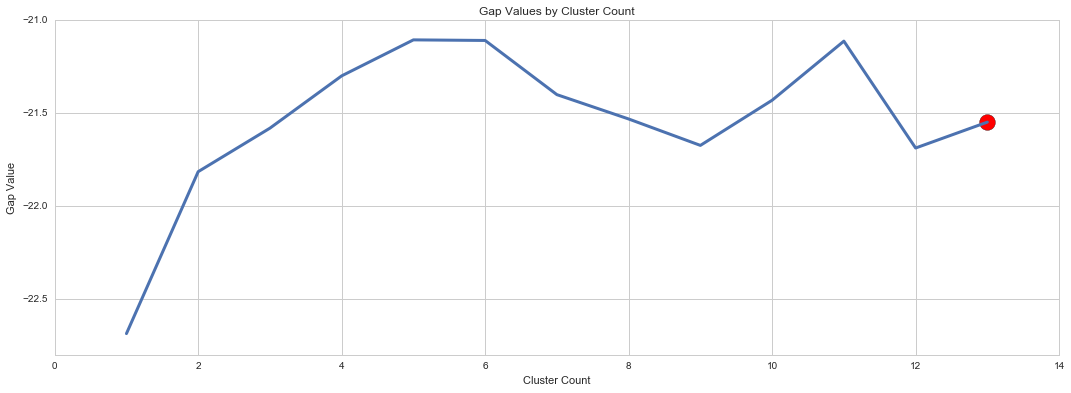

In [88]:
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == n].clusterCount, gapdf[gapdf.clusterCount == n].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

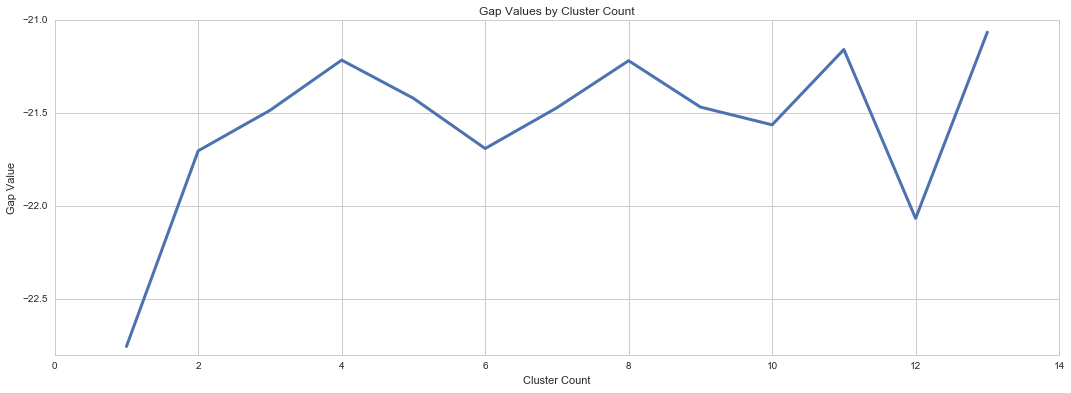

In [89]:
fig, ax = plt.subplots(figsize=(18,6))
num, gapdf = optimalK(km.cluster_centers_, maxClusters=15)
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == num].clusterCount, gapdf[gapdf.clusterCount == num].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

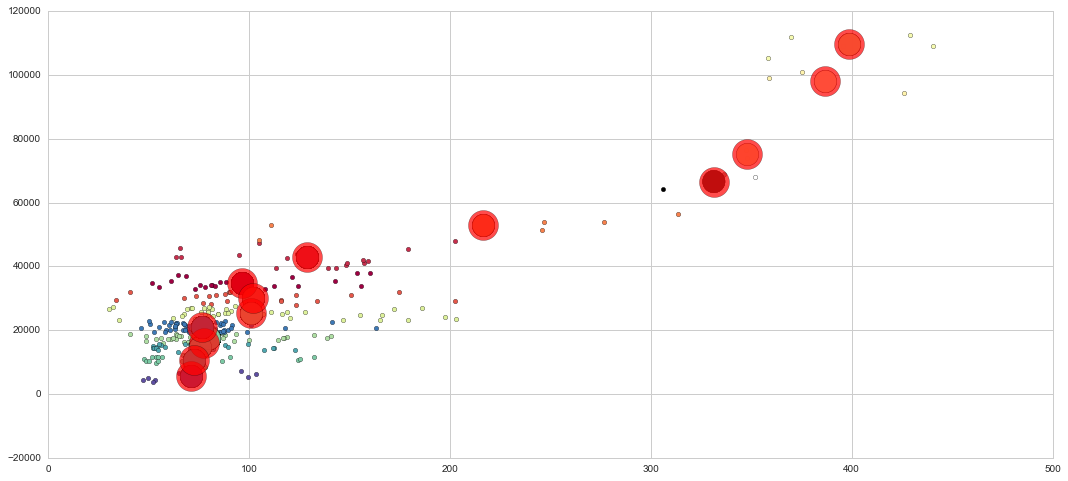

In [90]:
# Plot individual points colored to their cluster
fig, ax = plt.subplots(figsize=(18,8))
colors = plt.cm.Spectral(np.linspace(0, 1, len(df.elementcluster.unique())))
for color, label in zip(colors, df.elementcluster.unique()):
    tempdf = df[df.elementcluster == label]
    plt.scatter(tempdf.x, tempdf.y, c=color)
    


# Plot the cluster centroids from the individual points
colors = plt.cm.Spectral(np.linspace(0, 1, len(df.groupcluster.unique())))
for color, label in zip(colors, df.groupcluster.unique()):
    tempdf = df[df.groupcluster == label]
    plt.scatter(tempdf.cluster_x, tempdf.cluster_y, c=color, s=500, alpha=0.8)
    
    
# Plot the centroids of those cluster centroids (clusters of the clusters)
plt.scatter(km2.cluster_centers_[:,0], km2.cluster_centers_[:, 1], c='r', s=900, alpha=0.7, )
    
plt.show()

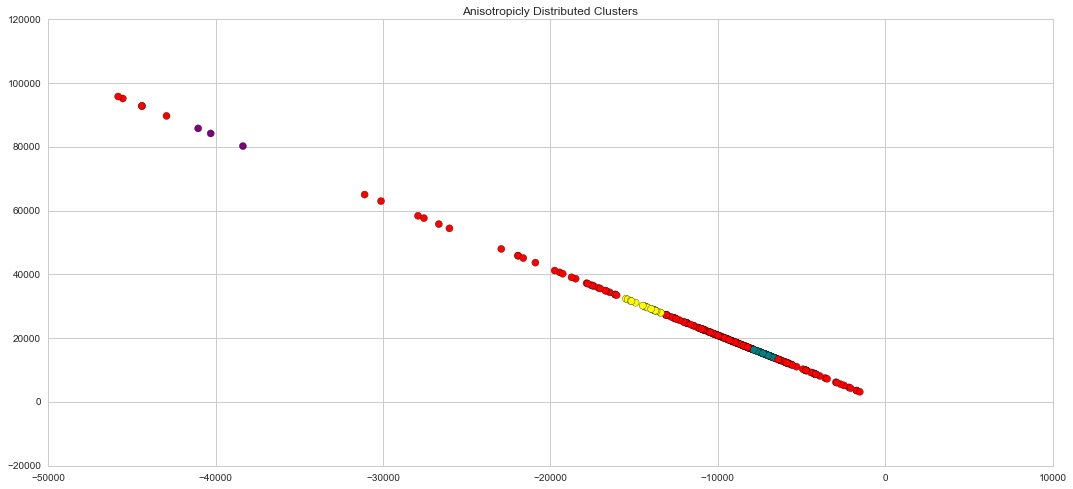

In [91]:
# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=n, random_state=0).fit_predict(X_aniso)

fig, ax = plt.subplots(figsize=(18, 8))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=get_colors(y_pred), s=50)
plt.title("Anisotropicly Distributed Clusters")

# Density Based Spatial Clustering

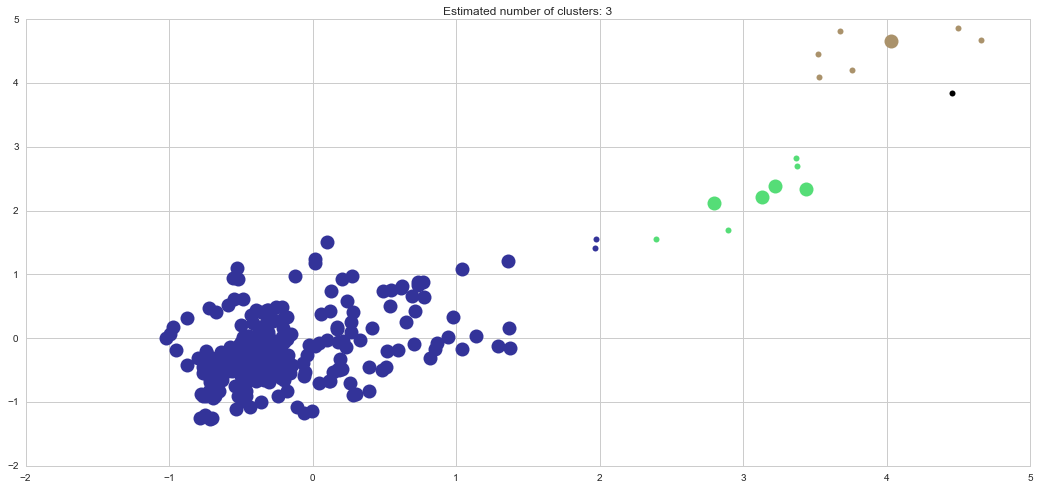

In [20]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=.9, min_samples=7).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = [plt.cm.terrain(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fix, ax = plt.subplots(figsize=(18,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Estimated Autocorrelation using Biased Estimator

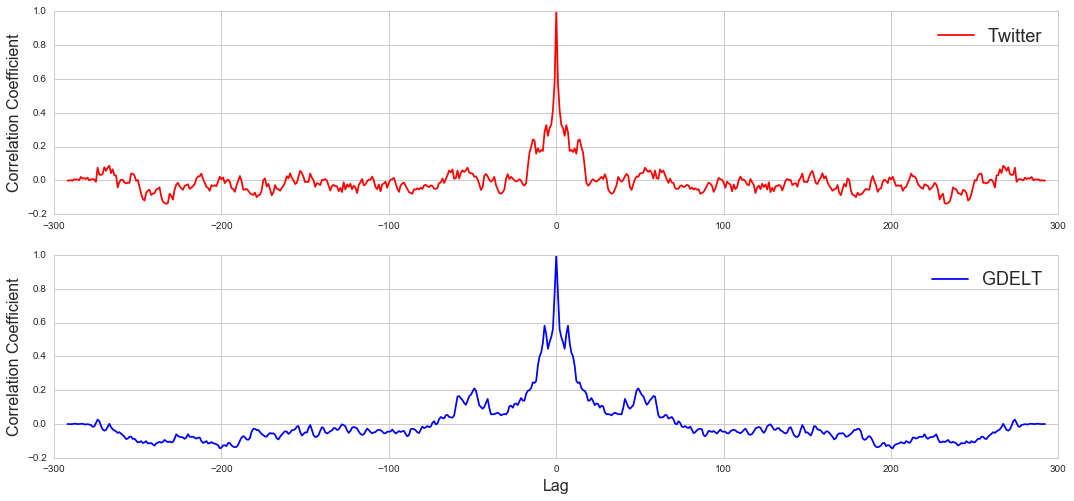

In [21]:
nx = 293 
x = np.array(tweet_activity)
y = np.array(gdelt_activity)

lags = np.arange(-nx + 1, nx) # so last value is nx - 1

# Remove sample mean.
xdm = x - x.mean()
ydm = y - y.mean()
autocorr_xdm = np.correlate(xdm, xdm, mode='full')
autocorr_ydm = np.correlate(ydm, ydm, mode='full')
# Normalize by the zero-lag value:
autocorr_xdm /= autocorr_xdm[nx - 1]
autocorr_ydm /= autocorr_ydm[nx - 1]


fig, (ax1,ax2) = plt.subplots(2,1, sharey=True, figsize=(18,8))
ax1.plot(lags, autocorr_xdm, 'r', label ='Twitter')
ax2.plot(lags, autocorr_ydm, 'b', label ='GDELT')
ax1.set_ylabel('Correlation Coefficient', fontsize=16)
ax2.set_ylabel('Correlation Coefficient', fontsize=16)
ax2.set_xlabel('Lag', fontsize = 16)
ax1.legend(loc='best', fontsize=18, ncol=2)
ax2.legend(loc='best', fontsize=18, ncol=2)
#ax1.grid(True)
#ax2.grid(True)

# Cross-Correlation Validation

In [23]:
def cross_correlation(twitter,gdelt,x):
    npts = x
    x = np.linspace(0, 1, npts)
    y1 = twitter
    y2 = gdelt

    lags = np.arange(-npts + 1, npts)
    ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
    ccor = ccov / (npts * y1.std() * y2.std())

    fig, axs = plt.subplots(nrows=2, figsize=(18,8))
    fig.subplots_adjust(hspace=0.2)
    ax = axs[0]
    ax.plot(x, y1, 'b', label='Twitter')
    ax.plot(x, y2, 'r', label='GDELT')
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=18, ncol=2)

    ax = axs[1]
    ax.plot(lags, ccor)
    ax.set_ylim(-1.1, 1.1)
    ax.set_ylabel('Cross-Correlation', fontsize=18)
    ax.set_xlabel('Lag of Twitter relative to GDELT', fontsize=18)

    maxlag = lags[np.argmax(ccor)]
    print("Max correlation is at lag %d" % maxlag)

Max correlation is at lag 0


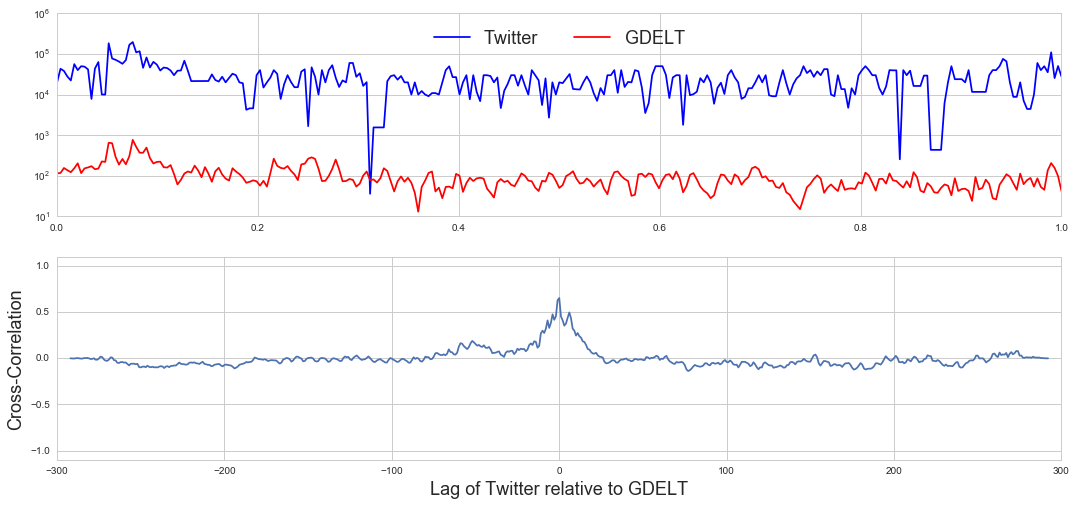

In [24]:
cross_correlation(np.array(pd.Series(tweet_activity).replace(0,None)), np.array(gdelt_activity), len(tweet_activity))

## Pre-Signing of Peace Agreement

September 11 - September 25: Maximum correlation is at lag 6. 

Max correlation is at lag 6


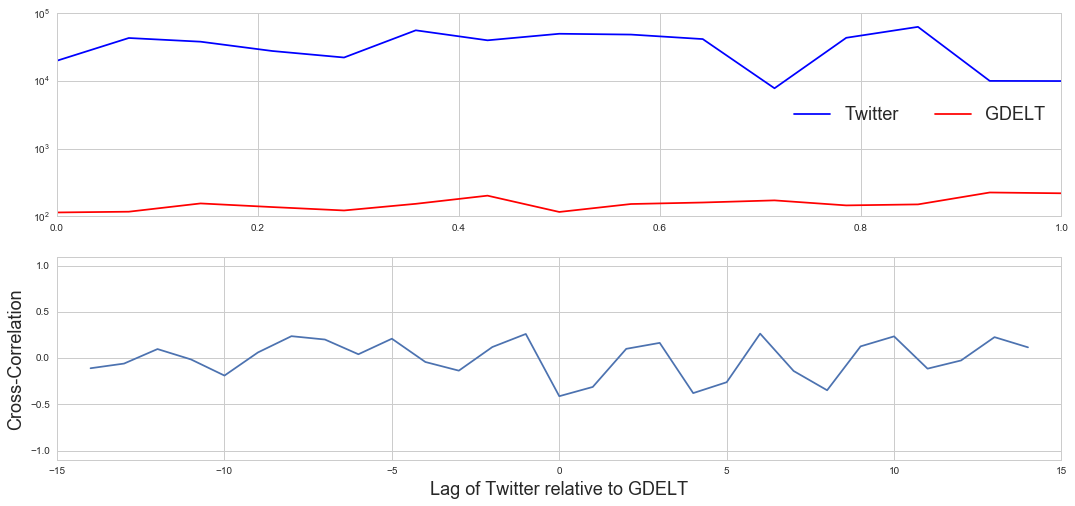

In [27]:
# Pre-Signing of Peace Agreement: September 11 - September 25
cross_correlation(np.array(tweet_activity[:15]), np.array(gdelt_activity[:15]), 15)

## Signing of Peace Agreements

September 22 - September 30: 4 day snapshot before and after signing of peace agreements. Maximum correlation at lag 0. Similar activity signal frequencies between news and social media.

Max correlation is at lag 0


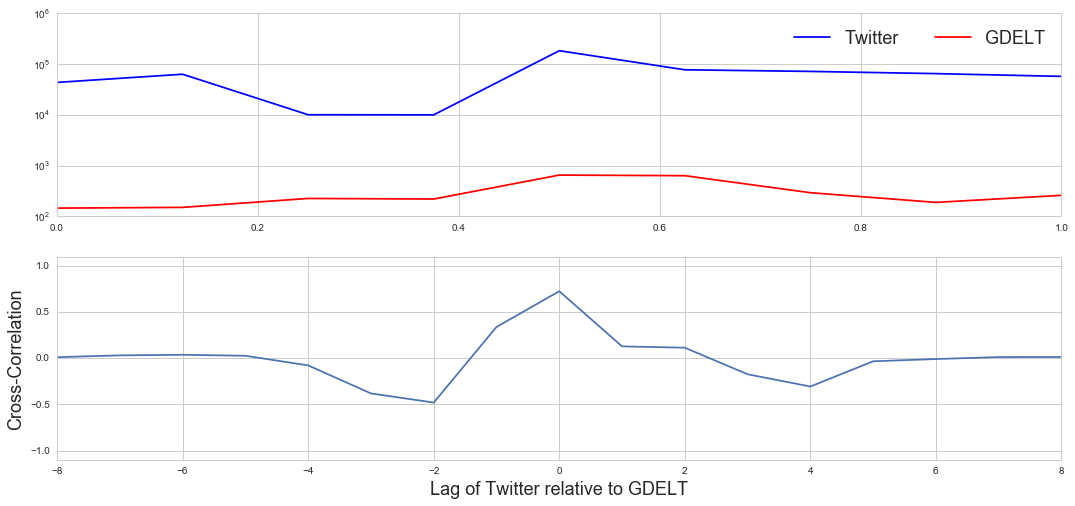

In [28]:
# Signing of Peace Agreement: September 22 - September 30 (t = 09/26, k = +-4)
cross_correlation(np.array(tweet_activity[11:20]), np.array(gdelt_activity[11:20]), 9)

## Plebiscite

September 25 - October 7: 5 day snapshot before and after the national referendum. Maximum correlation at lag -1. 

Max correlation is at lag -1


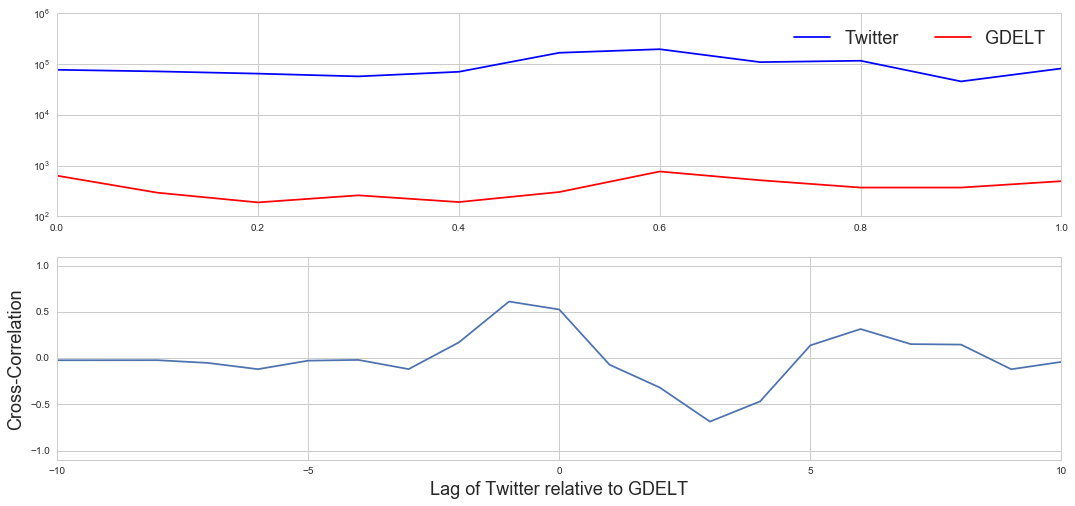

In [29]:
# Referendum Period: September 25 - October 7 (t = 10/02, k = +-5)
cross_correlation(np.array(tweet_activity[16:27]), np.array(gdelt_activity[16:27]), 11)

## Re-negotiation Period

October 7 - November 23: 23 day period before the revised peace agreement is signed. Maximum correlation at lag -1.

Max correlation is at lag -1


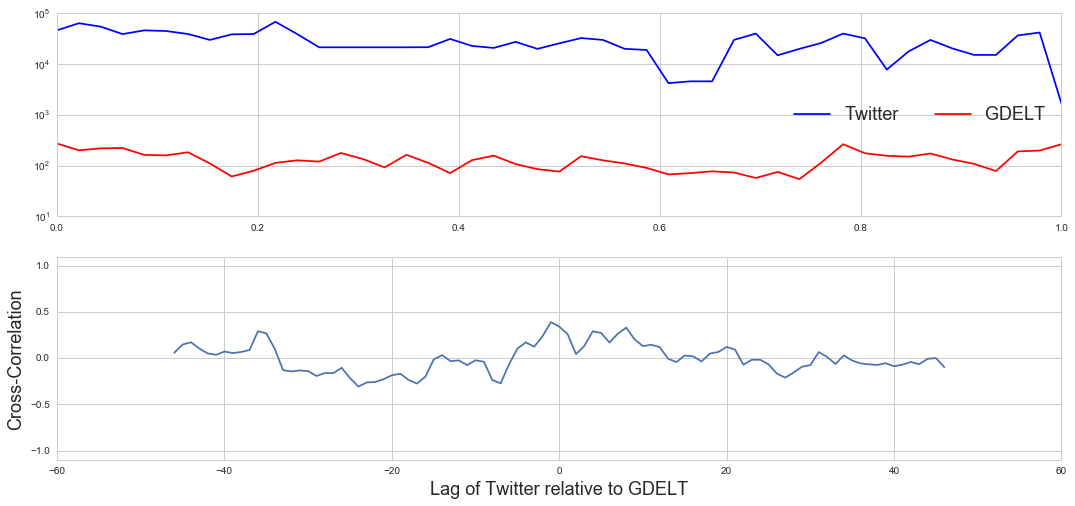

In [30]:
# Referendum Period: October 7 - November 23
cross_correlation(np.array(pd.Series(tweet_activity[27:74]).replace(0,None)), np.array(gdelt_activity[27:74]), 74-27)

## Signing of Revised Agreement

November 19 - November 2. 5 day snapshop before and after revised peace agreement is signed. Maximum correlation at lag 6.

Max correlation is at lag 6


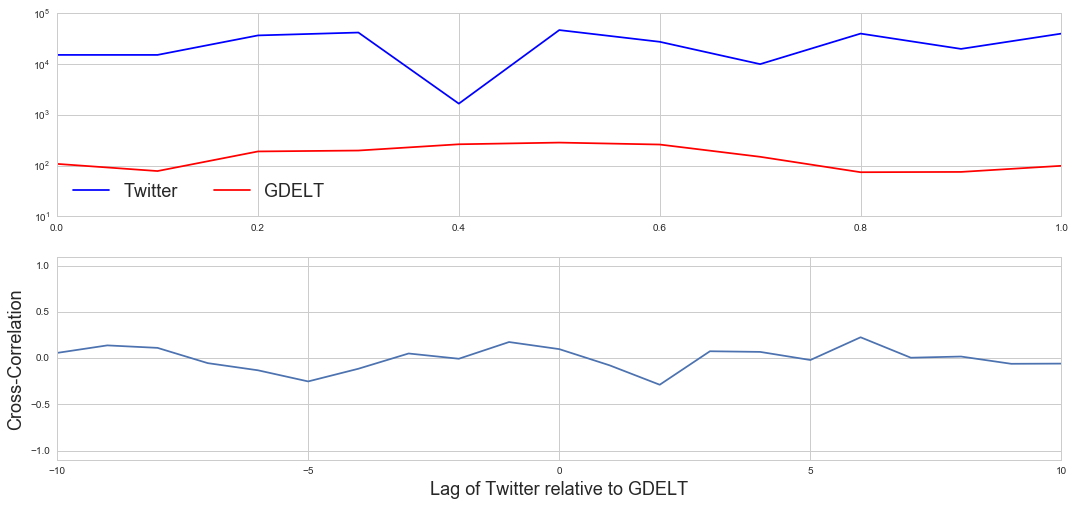

In [31]:
# Referendum Period: November 19 - November 29 (t = 10/02, k = +-5)
cross_correlation(np.array(pd.Series(tweet_activity[69:80]).replace(0,None)), np.array(gdelt_activity[69:80]), 80-69)

## Congress Approval

November 25 - December 5. 5 day snapshot before and after revised peace agreement is approved by congress. Maximum correlation at lag -1.

Max correlation is at lag -1


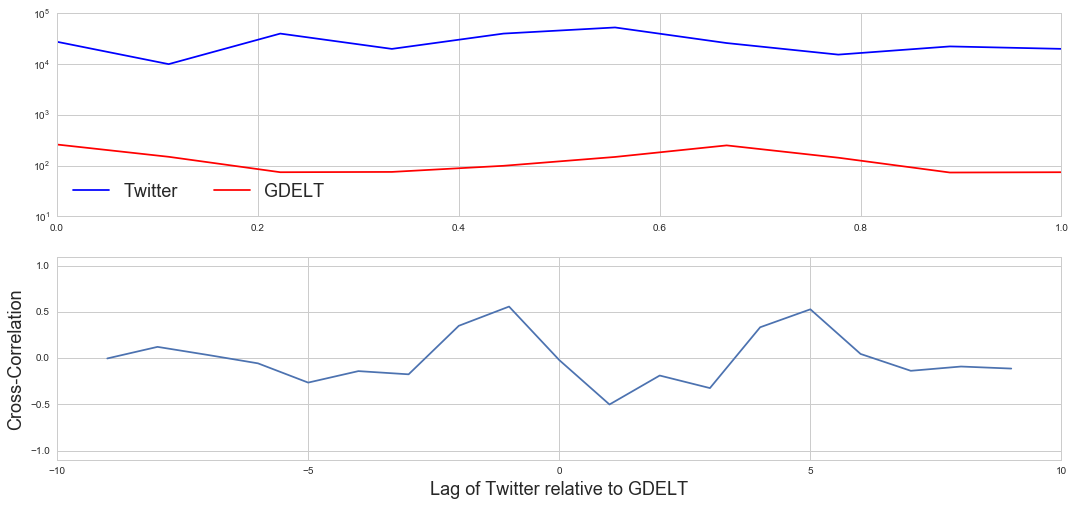

In [32]:
# Referendum Period: November 25 - December 5 (t = 10/02, k = +-5)
cross_correlation(np.array(pd.Series(tweet_activity[75:85]).replace(0,None)), np.array(gdelt_activity[75:85]), 85-75)

# Interarrival Time Distribution

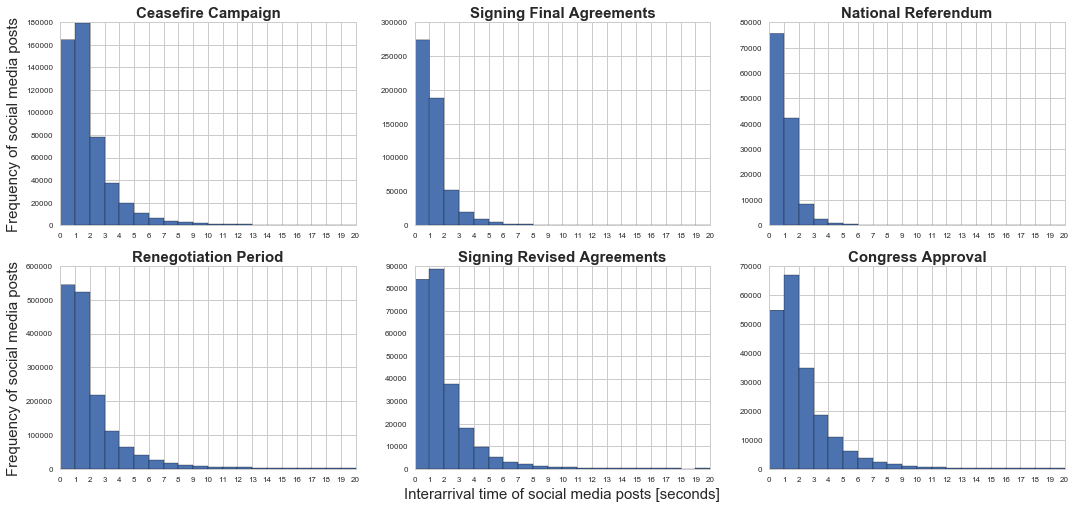

In [33]:
plt.figure(figsize=(18, 8))
bins = 20
lim = 30

plt.subplot(231)
plt.hist(inter_arrival_time('2016-09-11', '2016-09-26'),bins=bins, range=(0,bins), histtype='bar', align='mid', orientation='vertical')
plt.title('Ceasefire Campaign', fontsize=15, fontweight='bold')
plt.ylabel('Frequency of social media posts' , fontsize=15)
#plt.xlabel('Interarrival time of social media posts [seconds]', fontsize=15)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xticks(np.arange(0, lim, 1))
plt.xlim([0,bins])

plt.subplot(232)
plt.hist(inter_arrival_time('2016-09-20', '2016-09-30'),bins=bins, range=(0,bins), histtype='bar', align='mid', orientation='vertical')
plt.title('Signing Final Agreements', fontsize=15, fontweight='bold')
#plt.ylabel('Frequency of social media posts' , fontsize=15)
#plt.xlabel('Interarrival time of social media posts [seconds]', fontsize=15)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xticks(np.arange(0, lim, 1))
plt.xlim([0,bins])

plt.subplot(233)
plt.hist(inter_arrival_time('2016-10-01', '2016-10-03'),bins=bins, range=(0,bins), histtype='bar', align='mid', orientation='vertical')
plt.title('National Referendum', fontsize=15, fontweight='bold')
#plt.ylabel('Frequency of social media posts' , fontsize=15)
#plt.xlabel('Interarrival time of social media posts [seconds]', fontsize=15)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xticks(np.arange(0, lim, 1))
plt.xlim([0,bins])

plt.subplot(234)
plt.hist(inter_arrival_time('2016-10-04', '2016-11-25'),bins=bins, range=(0,bins), histtype='bar', align='mid', orientation='vertical')
plt.title('Renegotiation Period', fontsize=15, fontweight='bold')
plt.ylabel('Frequency of social media posts' , fontsize=15)
#plt.xlabel('Interarrival time of social media posts [seconds]', fontsize=15)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xticks(np.arange(0, lim, 1))
plt.xlim([0,bins])

plt.subplot(235)
plt.hist(inter_arrival_time('2016-11-20', '2016-11-30'),bins=bins, range=(0,bins), histtype='bar', align='mid', orientation='vertical')
plt.title('Signing Revised Agreements', fontsize=15, fontweight='bold')
#plt.ylabel('Frequency of social media posts' , fontsize=15)
plt.xlabel('Interarrival time of social media posts [seconds]', fontsize=15)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xticks(np.arange(0, lim, 1))
plt.xlim([0,bins])

plt.subplot(236)
plt.hist(inter_arrival_time('2016-11-27', '2016-12-03'),bins=bins, range=(0,bins), histtype='bar', align='mid', orientation='vertical')
plt.title('Congress Approval', fontsize=15, fontweight='bold')
#plt.ylabel('Frequency of social media posts' , fontsize=15)
#plt.xlabel('Interarrival time of social media posts [seconds]', fontsize=15)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xticks(np.arange(0, lim, 1))
plt.xlim([0,bins])
plt.show()